**Program**: 3_NSCH_AHR_Cluster_Analysis<br>
**Class**: Fall 2025, Machine Learning, Project<br>
**Member**: Vanessa Thorsten<br>
**Description**: This program reads in the analysis dataset NSCH_AHR_state.csv, which provides data summarized at the state-level. The following variables are kept and standardized, and cluster analysis is performed.<br>
- Percentage of the population not covered by private or public health insurance<br>
- Percent of children receiving at least one preventative care visit<br>
<br>
The comparison variable for the cluster analysis is the percentage of children who received by age 24 months all recommended doses of the combined seven-vaccine series: diphtheria and tetanus toxoids and acellular pertussis (DTaP) vaccine; measles, mumps and rubella (MMR) vaccine; poliovirus vaccine; Haemophilus influenzae type b (Hib) vaccine; hepatitis B (HepB) vaccine; varicella vaccine; and pneumococcal conjugate vaccine (PCV)<br>

**Outputs**: The following data visualizations are provided for the dataset:<br>

- Q2_insured_pcare_good_immun_scatter.png
- Q2_insured_pcare_good_immun_k.png
- Q2_insured_pcare_good_immun_elbow.png- 
Q2_insured_pcare_good_immun_silhouette.png
 - Q2_insured_pcare_good_immun_kmeans.png
- Q2_insured_pcare_good_immun_kmeans_correct.png
- Q2_insured_pcare_good_immun_dendrogram.png
- Q2_insured_pcare_good_immun_hc.png
- Q2_insured_pcare_good_immun_hc_correct.png
  
**Program History/Modifications**:<br>
09/15/2025    Initial Version

In [1]:
#Read in packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch
from scipy.cluster.hierarchy import fcluster
import math

In [2]:
#bug with using KMeans in windows. Address by setting the environment
#Warning said, "KMeans is known to have a memory leak on Windows with MKL, 
#when there are less chunks than available threads. You can avoid it by 
#setting the environment variable OMP_NUM_THREADS=1."
import os
os.environ["OMP_NUM_THREADS"] = "1"

In [3]:
#Combined state level data
df_state = pd.read_csv("NSCH_AHR_state.csv")
df_state.head()

,Unnamed: 0,STATE,nomChHlthSt_23_1.0_proportion,nomChHlthSt_23_2.0_proportion,PrevMed_23_1.0_proportion,PrevMed_23_2.0_proportion,K4Q01_1.0_proportion,K4Q01_2.0_proportion,smAdeqIns_23_1.0_proportion,smAdeqIns_23_2.0_proportion,...,immunizations,complete_hs,population_LT18,Poverty,primary_care_providers,public_health,support_engagement_annual,Uninsured,good_immun_cat,Region
0,0,AK,0.9245,0.0755,0.7562,0.2438,0.8580,0.1420,0.6341,0.3659,...,59.8,93.2,23.9,10.4,359.3,334.0,0.024,10.4,Low,West
1,1,AL,0.9022,0.0978,0.7939,0.2061,0.8134,0.1866,0.7404,0.2596,...,62.6,89.1,22.1,16.0,241.0,137.0,-0.745,8.5,Low,South
2,2,AR,0.9153,0.0847,0.7550,0.2450,0.7856,0.2144,0.6842,0.3158,...,62.0,89.3,23.0,16.3,241.4,128.0,-1.020,8.9,Low,South
3,3,AZ,0.8792,0.1208,0.7597,0.2403,0.7400,0.2600,0.6240,0.3760,...,62.9,89.4,21.3,12.6,258.2,84.0,0.125,9.9,Low,West
4,4,CA,0.8839,0.1161,0.7497,0.2503,0.7087,0.2913,0.7053,0.2947,...,59.8,84.8,21.7,12.0,229.7,173.0,0.199,6.4,Low,West


In [4]:
#As a reminder, look at the weights from the combined individual level data
#the counts for preventative care are weighted
df_fam = pd.read_csv("NSCH_fam.csv")
df_fam.head()

,Unnamed: 0,FIPSST,STATE,STATE_NAME,STRATUM,HHID,FORMTYPE,TOTKIDS_R,FWC,SC_AGE_YEARS,...,K4Q01,GOWHENSICK,UsualSck_23,smAdeqIns_23,smForgoneHC_23,nomAnxietyDep12to17_23,nomFlrish6mto5_23,nomFlrish6to17_23,ScreenTime_23,HrsSleep_23
0,0,6,CA,California,1,23043707,2,1,1318.476840,11,...,2.0,NaN,2.0,1.0,2.0,NaN,90.0,2.0,4.0,2.0
1,1,6,CA,California,1,23120547,3,2,978.499881,14,...,1.0,1.0,1.0,1.0,2.0,2.0,90.0,1.0,5.0,1.0
2,2,6,CA,California,1,23197456,3,1,904.191765,17,...,1.0,NaN,NaN,1.0,2.0,2.0,90.0,1.0,4.0,1.0
3,3,6,CA,California,1,23197458,3,2,1092.097256,12,...,1.0,1.0,1.0,1.0,2.0,2.0,90.0,1.0,4.0,1.0
4,4,6,CA,California,1,23235909,2,2,586.387870,10,...,2.0,NaN,2.0,2.0,2.0,NaN,90.0,1.0,5.0,1.0


In [5]:
df_fam['FWC'].describe()

count    54159.000000
mean      1302.431294
std       2331.079332
min         11.006690
25%        262.159242
50%        636.542554
75%       1410.243192
max      54078.402190
Name: FWC, dtype: float64

In [6]:
df_state.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51 entries, 0 to 50
Data columns (total 24 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Unnamed: 0                     51 non-null     int64  
 1   STATE                          51 non-null     object 
 2   nomChHlthSt_23_1.0_proportion  51 non-null     float64
 3   nomChHlthSt_23_2.0_proportion  51 non-null     float64
 4   PrevMed_23_1.0_proportion      51 non-null     float64
 5   PrevMed_23_2.0_proportion      51 non-null     float64
 6   K4Q01_1.0_proportion           51 non-null     float64
 7   K4Q01_2.0_proportion           51 non-null     float64
 8   smAdeqIns_23_1.0_proportion    51 non-null     float64
 9   smAdeqIns_23_2.0_proportion    51 non-null     float64
 10  healthy                        51 non-null     float64
 11  preventative_care              51 non-null     float64
 12  place_for_care                 51 non-null     float

### Standardization

In [7]:
#Reverse the direction of uninsured to percent insured to make the interpretation
#easier, so that both preventative care and insured go from low to high.
df_state['Insured'] = 100 - df_state['Uninsured']

df_state[['preventative_care','Uninsured','Insured']].describe().round(2)

,preventative_care,Uninsured,Insured
count,51.00,51.00,51.00
mean,80.27,7.18,92.82
std,4.20,2.68,2.68
min,69.80,2.60,83.60
25%,77.50,5.40,91.00
50%,80.20,6.50,93.50
75%,82.35,9.00,94.60
max,89.30,16.40,97.40


In [8]:
cols_for_clustering = ['preventative_care','Insured']

df_filtered = df_state[cols_for_clustering]

scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df_filtered), 
                            columns=df_filtered.columns, index=df_filtered.index)

#Add 'STATE',good immunization coverage back to the standardized DataFrame
df_state_std = pd.concat(
    [df_scaled, df_state[['STATE', 'good_immun_cat']]], 
    axis=1
)

print(df_state_std.head())
print(df_state_std.columns)

   preventative_care   Insured STATE good_immun_cat
0          -1.122213 -1.211135    AK            Low
1          -0.208795 -0.495532    AL            Low
2          -1.146250 -0.646185    AR            Low
3          -1.026063 -1.022819    AZ            Low
4          -1.266437  0.295399    CA            Low
Index(['preventative_care', 'Insured', 'STATE', 'good_immun_cat'], dtype='object')


In [9]:
df_state_std[['preventative_care', 'Insured']].describe().round(2)

,preventative_care,Insured
count,51.00,51.00
mean,-0.00,-0.00
std,1.01,1.01
min,-2.52,-3.47
25%,-0.67,-0.68
50%,-0.02,0.26
75%,0.50,0.67
max,2.17,1.73


In [10]:
df_state_std['good_immun_cat'].value_counts()

good_immun_cat
Medium or high    26
Low               25
Name: count, dtype: int64

In [11]:
# Variables of interest
df_cluster = df_state_std[['STATE','preventative_care','Insured', 'good_immun_cat']]

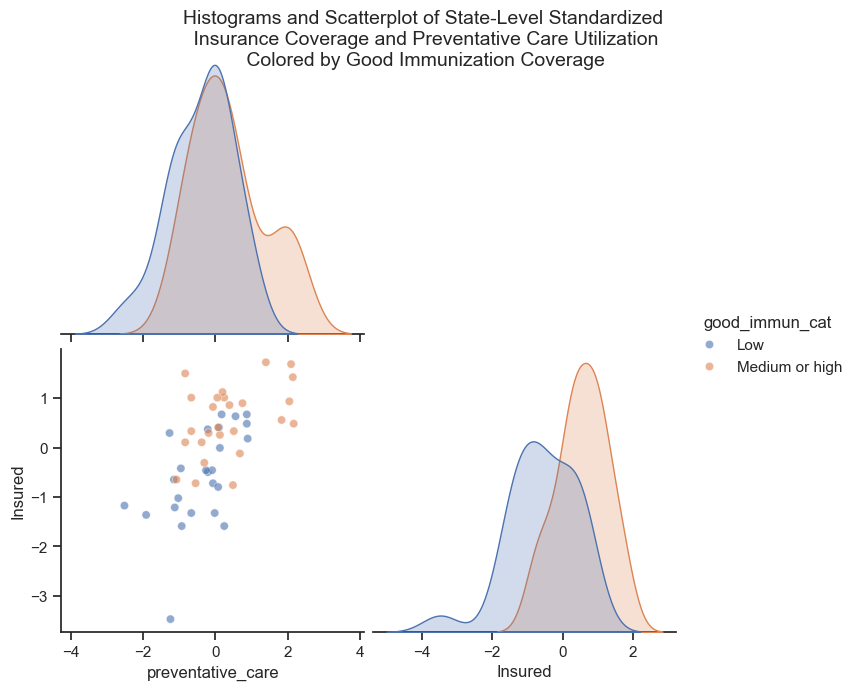

In [12]:
#Panel histograms and scatterplots with pairwise comparisons

# Set the plot style
sns.set(style="ticks")

# Create the pairplot
pairplot = sns.pairplot(
    df_cluster,
    hue='good_immun_cat',
    kind='scatter',
    corner=True,
    plot_kws={'alpha': 0.6},
    height=3.5,     # Height of each subplot
    aspect=1        # Aspect ratio (1 = square)
)

# Adjust space to fit the title
plt.subplots_adjust(top=0.92)

# Add a title
plt.suptitle('Histograms and Scatterplot of State-Level Standardized\n Insurance Coverage and Preventative Care Utilization\n Colored by Good Immunization Coverage', fontsize=14)
# Save the plot
plt.savefig('Q2_insured_pcare_good_immun_scatter.png', dpi=300)  

# Show plot
plt.show()

### K-Means Cluster Analysis

In [13]:
#Subset the data to the features for insured and preventative care
df_cluster2 = df_cluster[['Insured', 'preventative_care']]

C:\Users\vromm\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\vromm\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\vromm\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\vromm\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Window

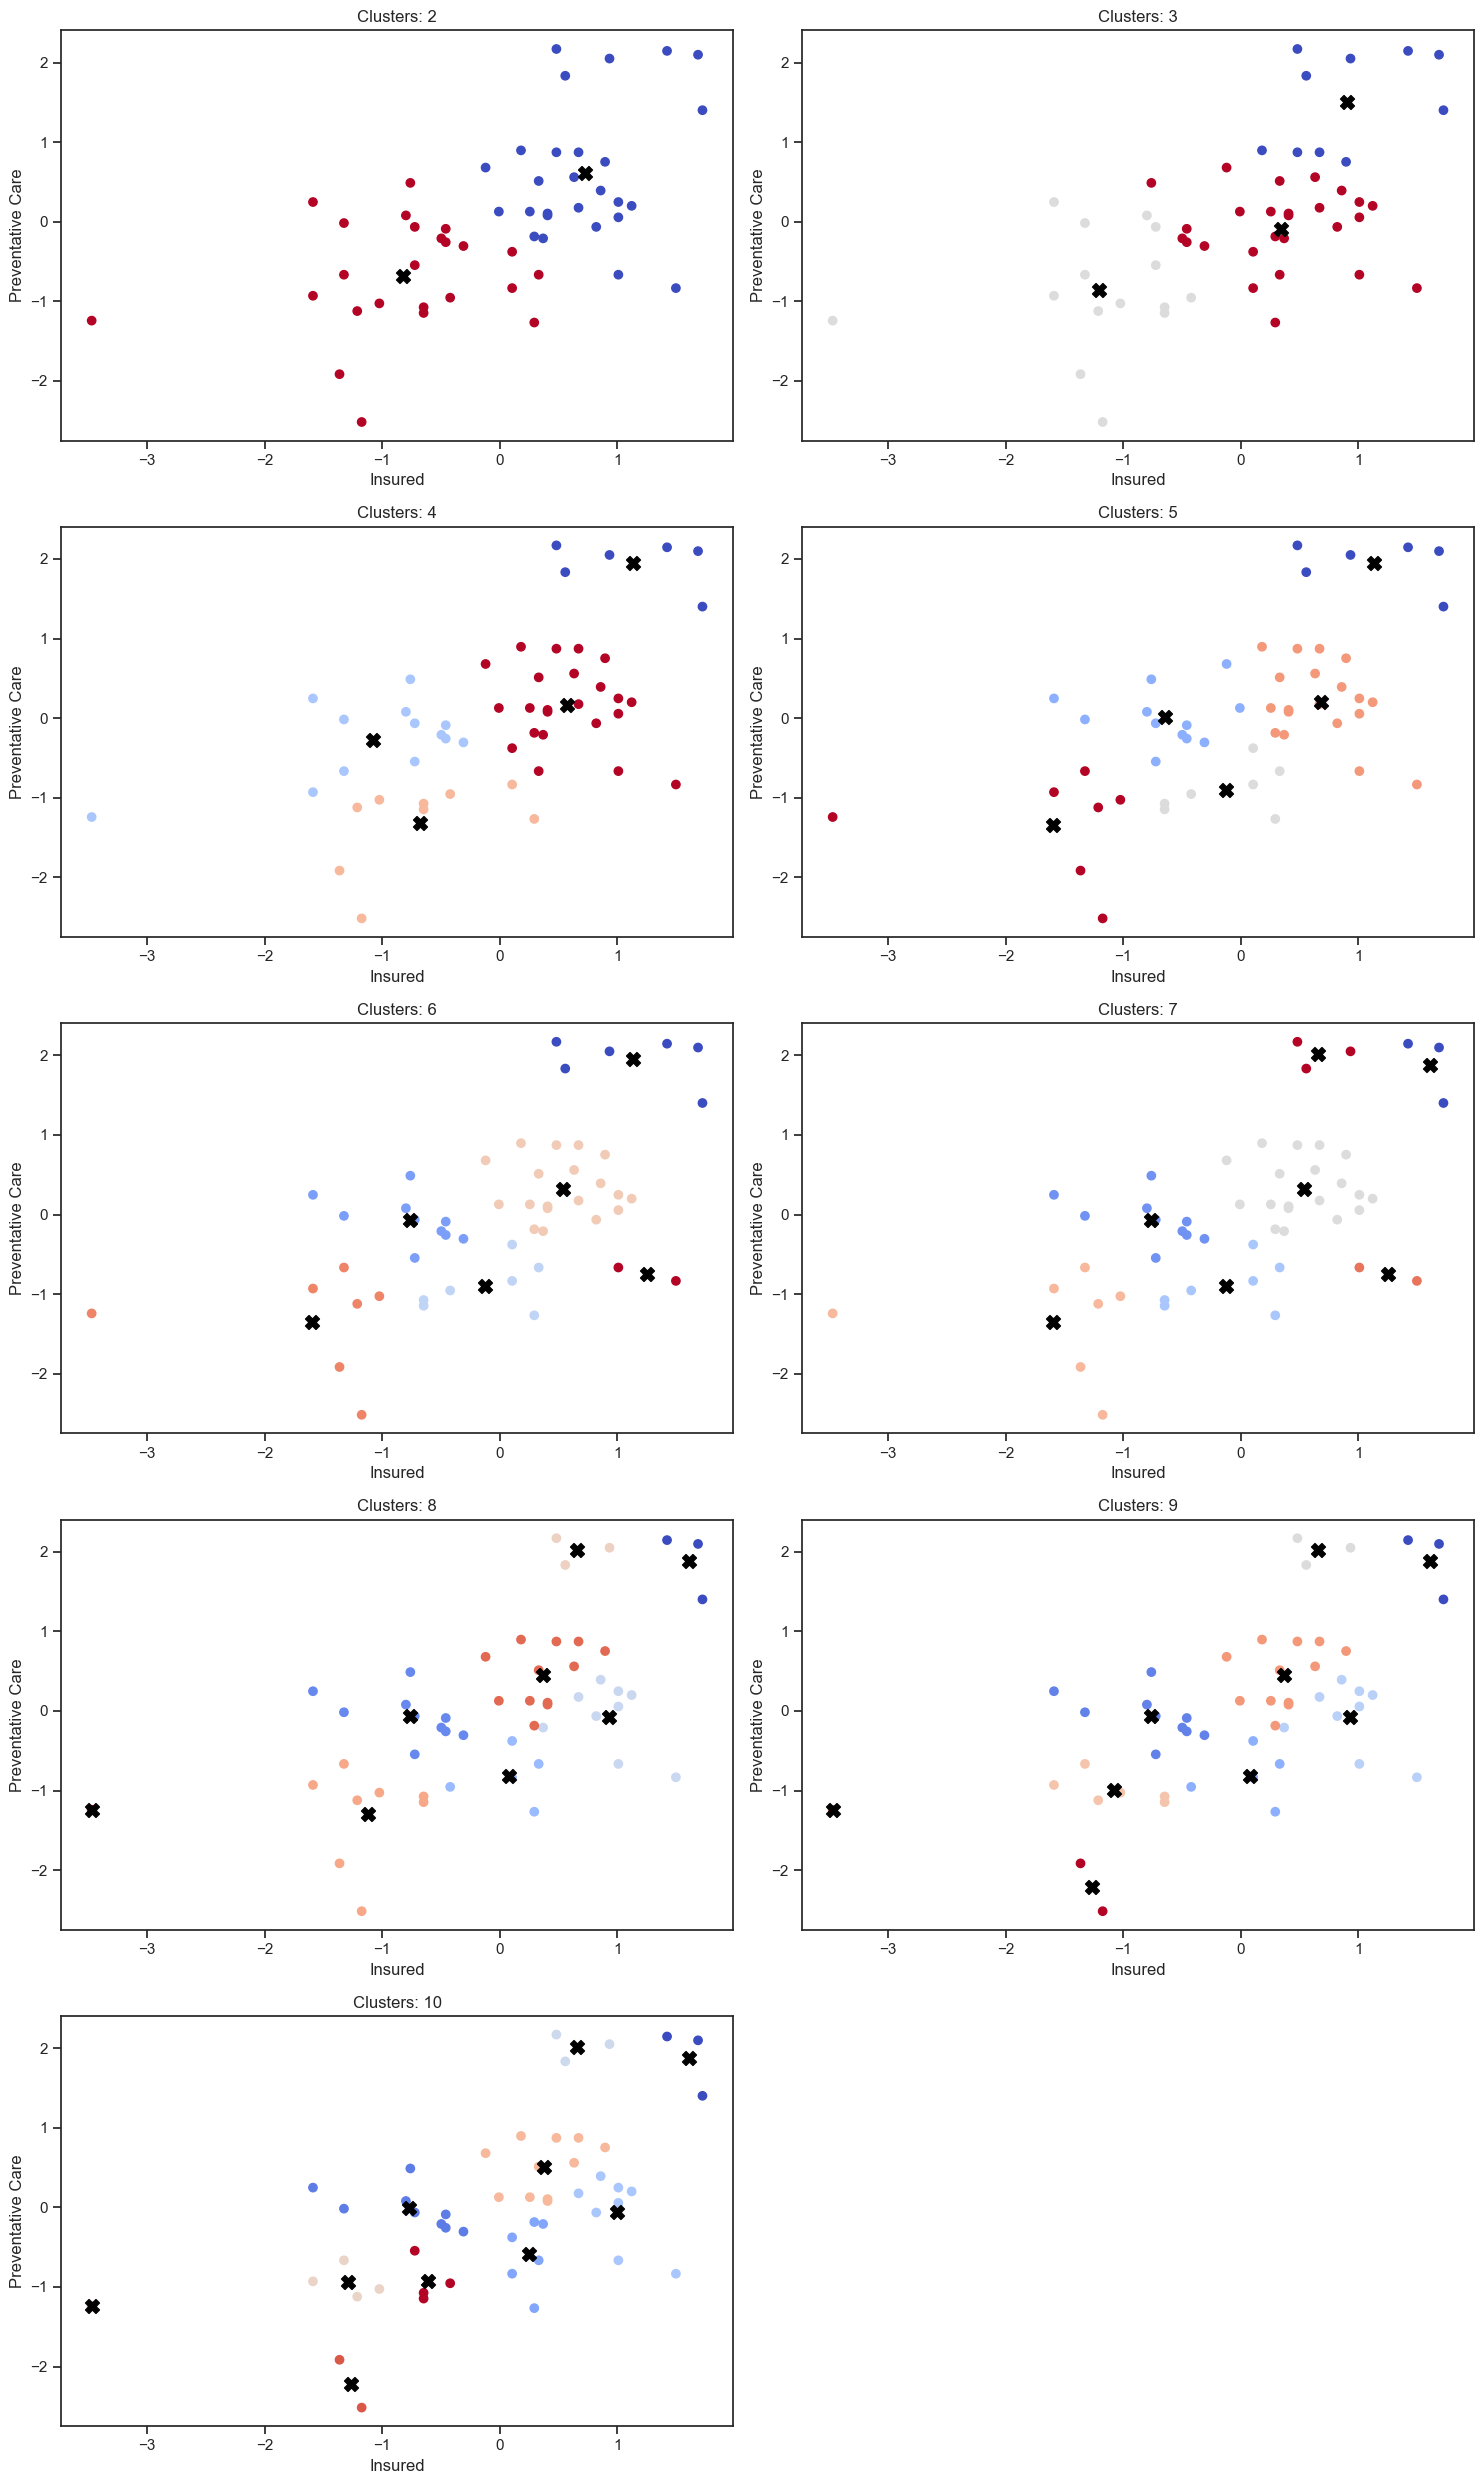

In [14]:
#Determine the best value for the number of clusters, k
#Try a range of values
k_range = range(2, 11)

#Store inertia and silhouette scores
inertia = []
silhouette_scores = []

#Set figure size
plt.figure(figsize=(15, 25)) 

for idx, k in enumerate(k_range, start=1):
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(df_cluster2)
    
    #Inertia (for elbow method)
    inertia.append(km.inertia_)
    
    #Silhouette Score
    score = silhouette_score(df_cluster2, km.labels_)
    silhouette_scores.append(score)

    #Graph the clustering for each k
    labels=km.labels_
    centers=km.cluster_centers_
    plt.subplot(5, 2, idx)  # 5 rows, 2 columns, plot number idx
    plt.scatter(df_cluster2['Insured'],df_cluster2['preventative_care'],
                c=labels, cmap='coolwarm')
    plt.scatter(centers[:, 0], centers[:, 1], color='black', marker='X', s=100)
    plt.title(f"Clusters: {k}", fontsize=12)
    plt.xlabel("Insured")
    plt.ylabel("Preventative Care")

# Save the plot
plt.tight_layout()
plt.savefig('Q2_insured_pcare_good_immun_k.png', dpi=300)  
plt.show()

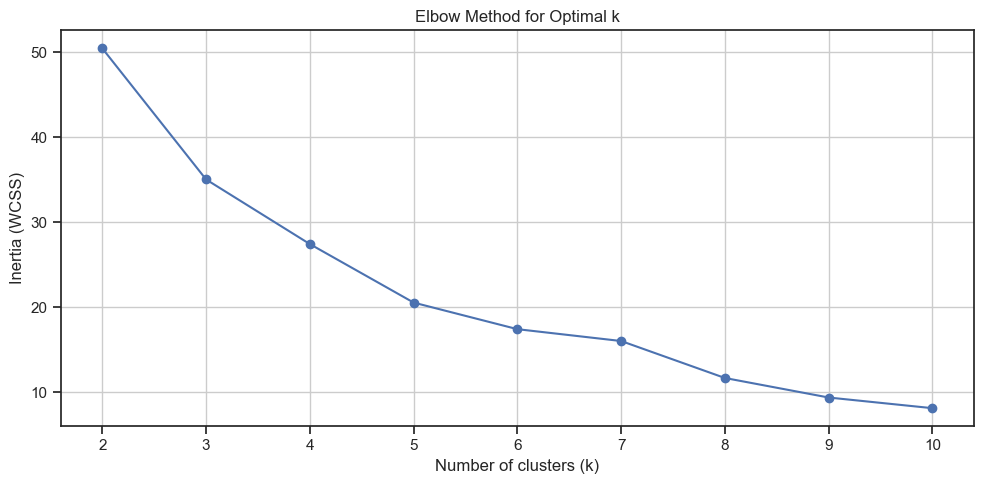

In [15]:
#Plot the elbow method results
plt.figure(figsize=(10, 5))
plt.plot(k_range, inertia, 'bo-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia (WCSS)')
plt.title('Elbow Method for Optimal k')
plt.grid(True)
# Save the plot
plt.tight_layout()
plt.savefig('Q2_insured_pcare_good_immun_elbow.png', dpi=300)  
plt.show()

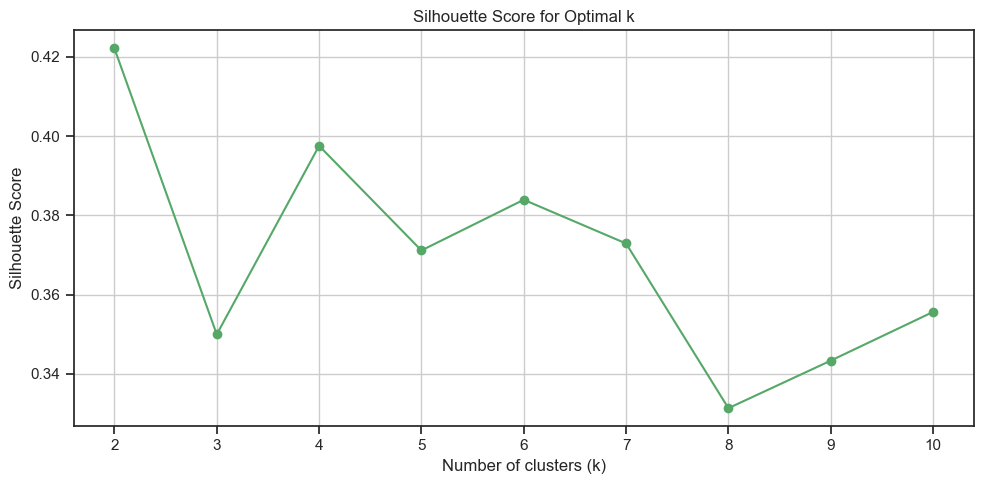

In [16]:
#Plot the silhouette method results
plt.figure(figsize=(10, 5))
plt.plot(k_range, silhouette_scores, 'go-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Optimal k')
plt.grid(True)
# Save the plot
plt.tight_layout()
plt.savefig('Q2_insured_pcare_good_immun_silhouette.png', dpi=300)  
plt.show()

The elbow method is inconclusive, as it progressively goes down after two clusters and there is now clear "elbow". The Silhouette Score is the highest for two clusters. Having two clusters is also supported by visual inspection of the clusters.  

C:\Users\vromm\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\vromm\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\vromm\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\vromm\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Window

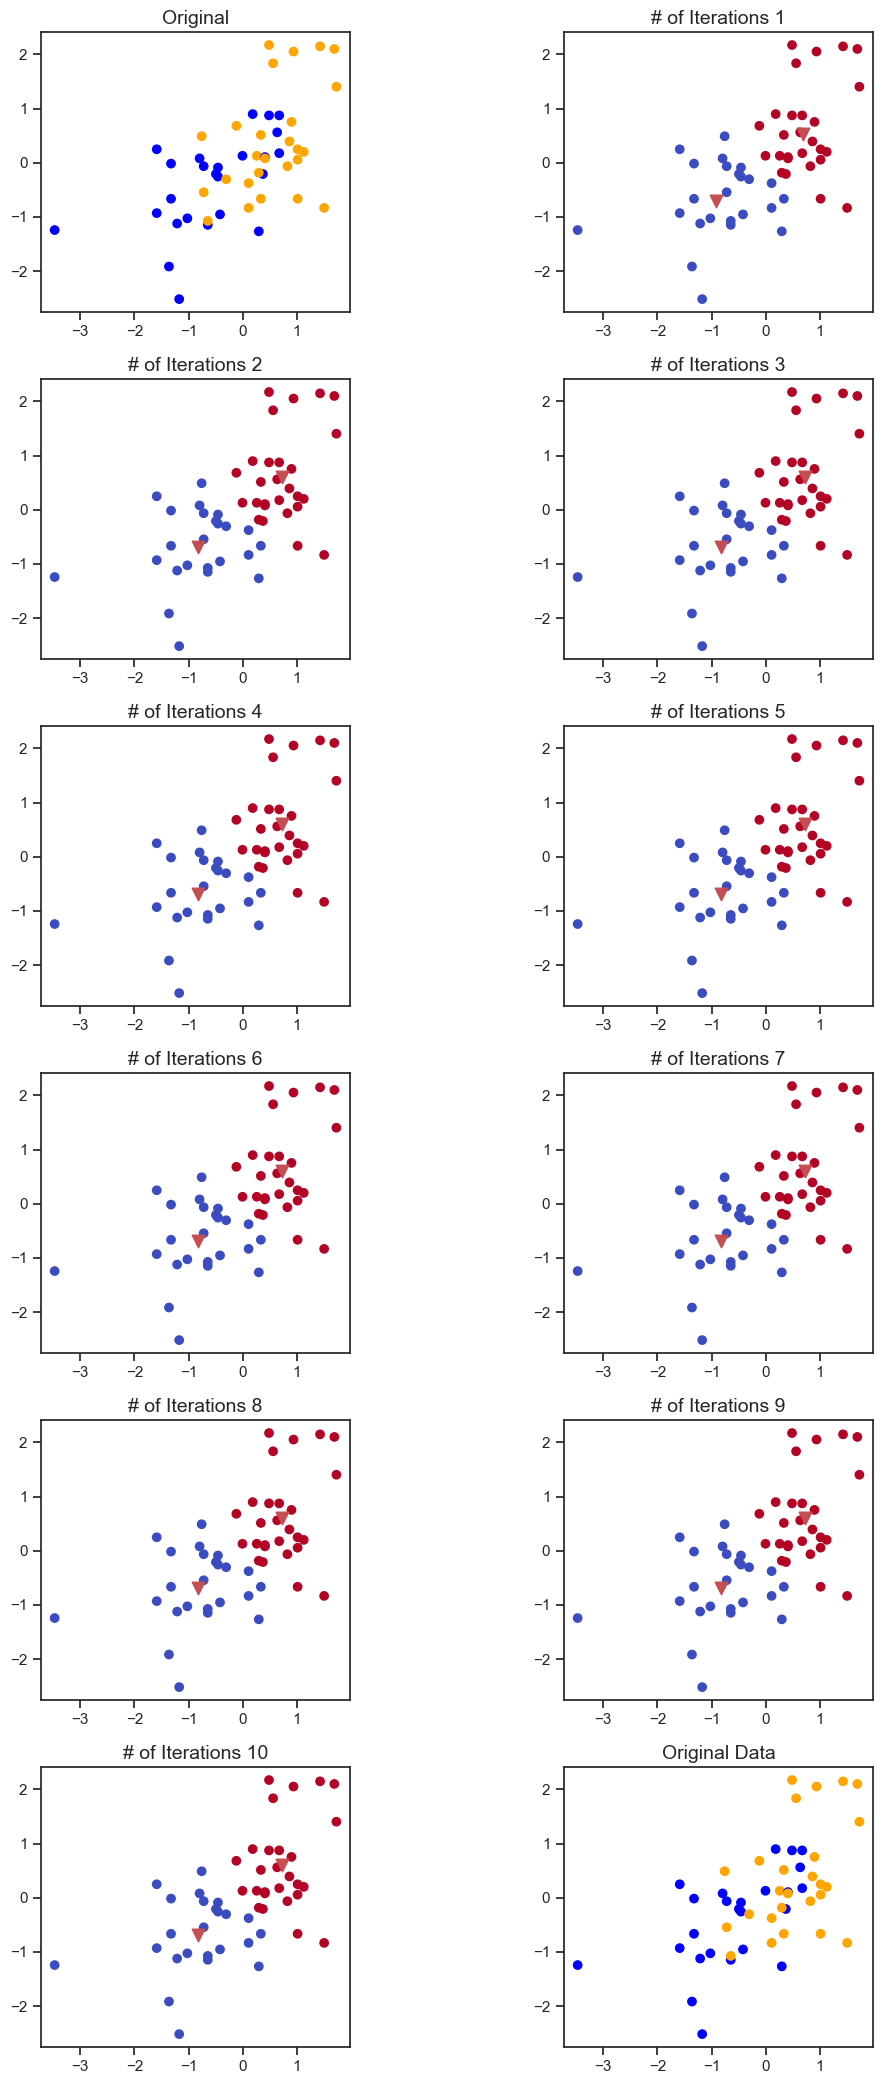

In [17]:
color_map1 = {
    'Low': 'blue',
    'Medium or high': 'orange'    
}

#Run K-Means with two clusters. Show the interations of the clustering
m=11

#Will need 12 plots total - one for each iteration + two for the original plots
total_plots = m + 1
#Number of rows
rows = math.ceil(total_plots / 2)
cols = 2

row_height = 3.5
fig_width = 12 

fig, axes = plt.subplots(rows, cols, figsize=(fig_width, rows * row_height))

axes = axes.flatten()

#Run K-Means and plot
for i in range(1, m):
    km = KMeans(n_clusters=2, max_iter=2*i-1, init='random', n_init=1, random_state=101)
    km.fit(df_cluster2)
    labels = km.labels_
    centers = km.cluster_centers_
    #Set the characteristics of the axes for the scatter plots 
    ax = axes[i]
    ax.scatter(df_cluster['Insured'], df_cluster['preventative_care'],
               c=labels, cmap='coolwarm')
    ax.scatter(x=centers[:, 0], y=centers[:, 1], color='r', marker='v', s=82)
    ax.set_title(f"# of Iterations {i}", fontsize=14)
    ax.set_aspect('equal')
    #If last run output the clusters
    if i == (m - 1):
        df_state_std['cluster_insured_pcare'] = km.fit_predict(df_cluster2)

# First and last subplots for original data
true_colors = df_cluster['good_immun_cat'].map(color_map1)

axes[0].scatter(df_cluster['Insured'], df_cluster['preventative_care'],
                c=true_colors, cmap='coolwarm')
axes[0].set_title("Original", fontsize=14)
axes[0].set_aspect('equal')

axes[m].scatter(df_cluster['Insured'], df_cluster['preventative_care'],
                c=true_colors, cmap='coolwarm')
axes[m].set_title("Original Data", fontsize=14)
axes[m].set_aspect('equal')

# Layout and save
plt.tight_layout()
plt.savefig("Q2_insured_pcare_good_immun_kmeans.png", dpi=300)
plt.show()

In [18]:
df_state_std['cluster_insured_pcare'].value_counts()

cluster_insured_pcare
1    27
0    24
Name: count, dtype: int64

Confusion matrix:
 [[17  8]
 [ 7 19]]
Best Accuracy: 0.7059
Misclassification Rate: 0.2941


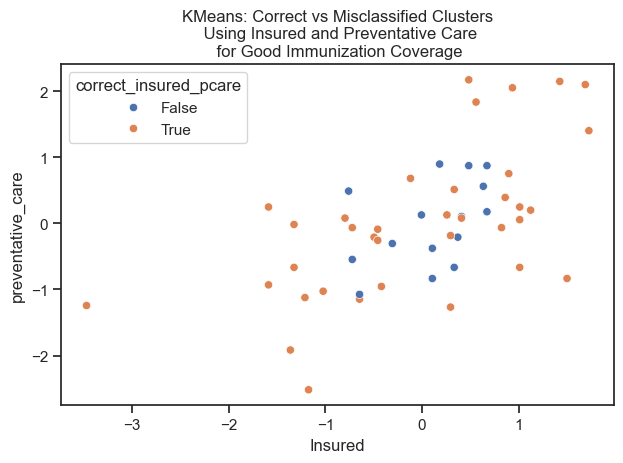

In [19]:
#True labels and predicted cluster labels

value_map = {
    'Low': 0,
    'Medium or high': 1
}

true_labels = df_state_std['good_immun_cat'].map(value_map)
cluster_labels = df_state_std['cluster_insured_pcare']

#Confusion matrix
cm = confusion_matrix(true_labels, cluster_labels)
print("Confusion matrix:\n", cm)

#Evaluate both possible cluster label assignments
accuracy1 = accuracy_score(true_labels, cluster_labels)
accuracy2 = accuracy_score(true_labels, 1 - cluster_labels)

#Use the mapping with higher accuracy
if accuracy1 >= accuracy2:
    best_labels = cluster_labels
    best_accuracy = accuracy1
else:
    best_labels = 1 - cluster_labels
    best_accuracy = accuracy2

#Misclassification rate
misclassification_rate = 1 - best_accuracy
print(f"Best Accuracy: {best_accuracy:.4f}")
print(f"Misclassification Rate: {misclassification_rate:.4f}")

#Mark correct classifications
df_state_std['correct_insured_pcare'] = (true_labels == best_labels)

sns.scatterplot(data=df_state_std, x='Insured', y='preventative_care', hue='correct_insured_pcare')
plt.title('KMeans: Correct vs Misclassified Clusters\n Using Insured and Preventative Care\n for Good Immunization Coverage')
plt.tight_layout()
plt.savefig('Q2_insured_pcare_good_immun_kmeans_correct.png', dpi=300)  
plt.show()

### Hierarchical Cluster Analysis

In [20]:
#Retry using a hierarchical clustering model. You do not need to specify the number of clusters
hc = AgglomerativeClustering(metric='cosine', linkage = 'average')
cluster_labels = hc.fit_predict(df_cluster2)

#Assign the resulting cluster labels to the original dataframe
df_state_std['cluster_hc_insured_pcare'] = cluster_labels

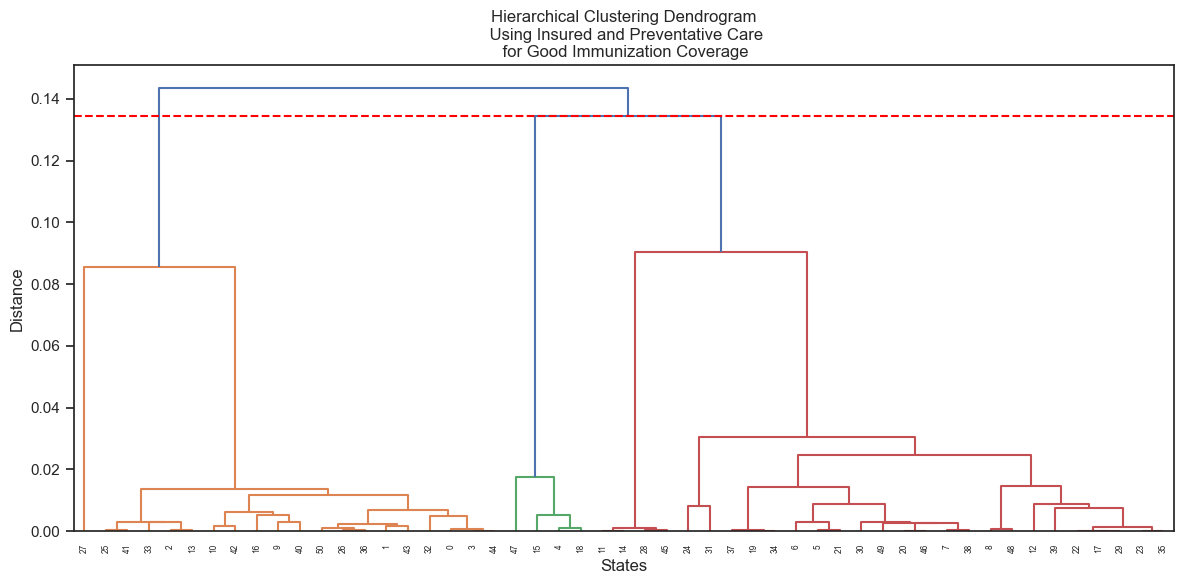

In [21]:
plt.figure(figsize=(12, 6))
#Compute the linkage matrix using average method with cosine
Z = sch.linkage(df_cluster2, metric='cosine') 
dendrogram = sch.dendrogram(Z)
#Add a line at 2 clusters
plt.axhline(y=Z[-2, 2], c='red', linestyle='--', label='Cut for 2 clusters')
plt.title('Hierarchical Clustering Dendrogram\n Using Insured and Preventative Care\n for Good Immunization Coverage')
plt.xlabel('States')
plt.ylabel('Distance')
plt.tight_layout()
plt.savefig('Q2_insured_pcare_good_immun_dendrogram.png', dpi=300)  
plt.show()


#By default, fcluster() returns labels 1 and 2, rather than 0 and 1. 
#Recode to 0/1 by subtracting 1
df_state_std['cluster_2_hc_insured_pcare'] = fcluster(Z, t=2, criterion='maxclust') - 1

In [22]:
df_state_std['cluster_2_hc_insured_pcare'].value_counts()

cluster_2_hc_insured_pcare
1    31
0    20
Name: count, dtype: int64

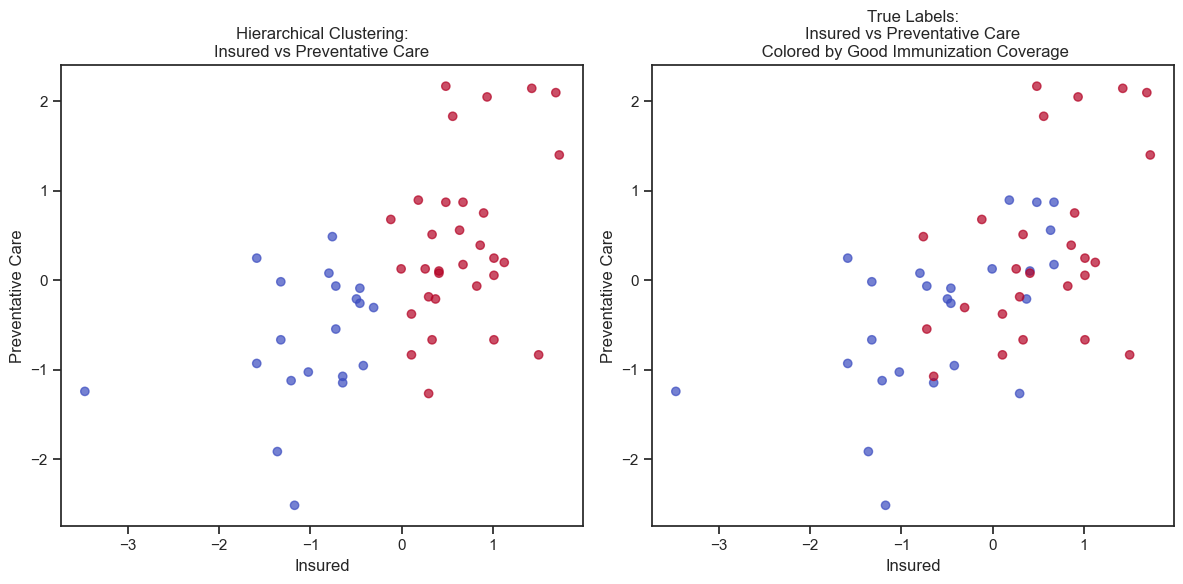

In [23]:
value_map2 = {
    'Low': 0,
    'Medium or high': 1
}

#True labels and predicted cluster labels
true_labels = df_state_std['good_immun_cat'].map(value_map2)
cluster_labels = df_state_std['cluster_2_hc_insured_pcare']

# Create figure with 1 row, 2 columns
plt.figure(figsize=(12, 6))

# Subplot 1: Clustering from HC
plt.subplot(1, 2, 1)
plt.scatter(df_cluster2['Insured'], df_cluster2['preventative_care'],
            c=cluster_labels, cmap='coolwarm', alpha=0.7)
plt.title("Hierarchical Clustering:\nInsured vs Preventative Care", fontsize=12)
plt.xlabel("Insured")
plt.ylabel("Preventative Care")

# Subplot 2: Ground-truth Labels
plt.subplot(1, 2, 2)
plt.scatter(df_cluster2['Insured'], df_cluster2['preventative_care'],
            c=true_labels, cmap='coolwarm', alpha=0.7)
plt.title("True Labels:\nInsured vs Preventative Care\n Colored by Good Immunization Coverage", fontsize=12)
plt.xlabel("Insured")
plt.ylabel("Preventative Care")

# Adjust layout and save
plt.tight_layout()
plt.savefig('Q2_insured_pcare_good_immun_hc.png', dpi=300)
plt.show()


Confusion matrix:
 [[16  9]
 [ 4 22]]
Best Accuracy: 0.7451
Misclassification Rate: 0.2549


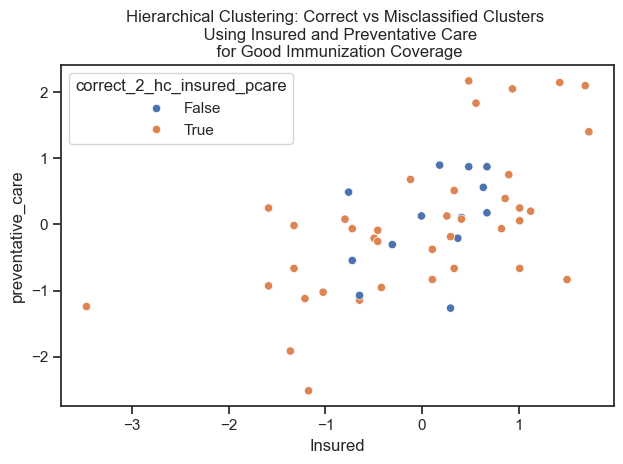

In [24]:
#Confusion matrix
cm = confusion_matrix(true_labels, cluster_labels)
print("Confusion matrix:\n", cm)

#Evaluate both possible cluster label assignments
accuracy1 = accuracy_score(true_labels, cluster_labels)
accuracy2 = accuracy_score(true_labels, 1 - cluster_labels)

#Use the mapping with higher accuracy
if accuracy1 >= accuracy2:
    best_labels = cluster_labels
    best_accuracy = accuracy1
else:
    best_labels = 1 - cluster_labels
    best_accuracy = accuracy2

#Misclassification rate
misclassification_rate = 1 - best_accuracy
print(f"Best Accuracy: {best_accuracy:.4f}")
print(f"Misclassification Rate: {misclassification_rate:.4f}")

#Mark correct classifications
df_state_std['correct_2_hc_insured_pcare'] = (true_labels == best_labels)

sns.scatterplot(data=df_state_std, x='Insured', y='preventative_care', hue='correct_2_hc_insured_pcare')
plt.title('Hierarchical Clustering: Correct vs Misclassified Clusters \n Using Insured and Preventative Care\n for Good Immunization Coverage')
plt.tight_layout()
plt.savefig('Q2_insured_pcare_good_immun_hc_correct.png', dpi=300)  
plt.show()

In [25]:
#Save to CSV
df_state_std[['STATE','preventative_care','Insured', 'good_immun_cat',
              'cluster_insured_pcare','correct_insured_pcare', 
              'cluster_2_hc_insured_pcare', 'correct_2_hc_insured_pcare']].to_csv("df_state_std_cluster.csv", index=False)

In [26]:
df_state_std[['STATE','preventative_care','Insured', 'good_immun_cat',
              'cluster_insured_pcare','correct_insured_pcare', 
              'cluster_2_hc_insured_pcare', 'correct_2_hc_insured_pcare']]

,STATE,preventative_care,Insured,good_immun_cat,cluster_insured_pcare,correct_insured_pcare,cluster_2_hc_insured_pcare,correct_2_hc_insured_pcare
0,AK,-1.122213,-1.211135,Low,0,True,0,True
1,AL,-0.208795,-0.495532,Low,0,True,0,True
2,AR,-1.146250,-0.646185,Low,0,True,0,True
3,AZ,-1.026063,-1.022819,Low,0,True,0,True
4,CA,-1.266437,0.295399,Low,0,True,1,False
5,CO,0.896922,0.182409,Low,1,False,1,False
6,CT,1.834377,0.559042,Medium or high,1,True,1,True
7,DC,2.098788,1.688943,Medium or high,1,True,1,True
8,DE,0.127728,0.257736,Medium or high,1,True,1,True
9,FL,-0.016496,-1.324126,Low,0,True,0,True
